# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

(n_samples, n_features) = data.shape

Wholesale customers dataset has 440 samples with 6 features each.


## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [2]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [3]:
total_spend = data.sum(axis=1)
min_spender = total_spend.argmin()
min_spend = total_spend.min()
max_spender = total_spend.argmax()
max_spend = total_spend.max()
print "min spender:" , min_spender , "min spend:" , min_spend
print "max spender:" , max_spender , "max spend:" , max_spend, "\n"

min_spender_per_category = data.idxmin(axis=0)
max_spender_per_category = data.idxmax(axis=0)
print "min spenders:"
print min_spender_per_category, "\n"
print "max spenders:"
print max_spender_per_category, "\n"

min_spend_category = data.idxmin(axis=1)
max_spend_category = data.idxmax(axis=1)

print "min spend category count:"
print min_spend_category.value_counts(), "\n"
print "max spend category count:" 
print max_spend_category.value_counts(), "\n"

min spender: 154 min spend: 904
max spender: 85 max spend: 199891 

min spenders:
Fresh                95
Milk                154
Grocery              75
Frozen              420
Detergents_Paper     75
Delicatessen        109
dtype: int64 

max spenders:
Fresh               181
Milk                 86
Grocery              85
Frozen              325
Detergents_Paper     85
Delicatessen        183
dtype: int64 

min spend category count:
Detergents_Paper    192
Delicatessen        132
Frozen               95
Fresh                17
Milk                  3
Grocery               1
dtype: int64 

max spend category count:
Fresh               246
Grocery             126
Milk                 42
Frozen               22
Delicatessen          3
Detergents_Paper      1
dtype: int64 



In [4]:
for i in xrange(0,n_samples):
    if min_spend_category[i]=='Grocery':
       print 'min Grocery', i
    if min_spend_category[i]=='Milk':
       print 'min Milk', i
    if max_spend_category[i]=='Detergents_Paper':
       print 'max Detergents_Paper', i
    if max_spend_category[i]=='Delicatessen':
       print 'max Delicatessen', i

min Milk 22
min Milk 71
min Grocery 75
max Delicatessen 183
min Milk 186
max Detergents_Paper 228
max Delicatessen 372
max Delicatessen 411


In [5]:
indices_of_interest = [22, 71, 75, 85, 86, 154, 183, 186, 228, 372, 411]

minmax_df = pd.DataFrame(
    {'min spend category': min_spend_category.iloc[indices_of_interest],
     'max spend category': max_spend_category.iloc[indices_of_interest]},
    index=indices_of_interest)

samples_df = pd.DataFrame(data.loc[indices_of_interest], columns = data.keys(), index=indices_of_interest)

display(minmax_df.join(samples_df))

,max spend category,min spend category,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
22,Fresh,Milk,31276,1917,4469,9408,2381,4334
71,Grocery,Milk,18291,1266,21042,5373,4173,14472
75,Fresh,Grocery,20398,1137,3,4407,3,975
85,Grocery,Frozen,16117,46197,92780,1026,40827,2944
86,Milk,Delicatessen,22925,73498,32114,987,20070,903
154,Fresh,Detergents_Paper,622,55,137,75,7,8
183,Delicatessen,Detergents_Paper,36847,43950,20170,36534,239,47943
186,Frozen,Milk,3009,521,854,3470,949,727
228,Detergents_Paper,Delicatessen,1869,577,572,950,4762,203
372,Delicatessen,Detergents_Paper,3884,3801,1641,876,397,4829


In [6]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [85, 228, 372]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

display(data.describe().loc[['mean', '25%', '50%', '75%']])

sample_percentiles = samples.copy()
import scipy.stats as stats
for feature in data.keys():
    for i in xrange(0, len(indices)):
        sample_percentiles[feature].loc[i] = stats.percentileofscore(data[feature], samples[feature].loc[i], kind='mean')
display(sample_percentiles.round(decimals=1))

100. * data.rank(axis=0, pct=True).iloc[indices].round(decimals=3)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,16117,46197,92780,1026,40827,2944
1,1869,577,572,950,4762,203
2,3884,3801,1641,876,397,4829


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000


//anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,73.1,99.4,99.9,36.7,99.9,89.9
1,15.6,4.3,2.6,34.9,80.3,11.0
2,28.3,53.1,14.9,31.2,35.2,95.3


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
85,73.2,99.5,100.0,36.8,100.0,90.0
228,15.7,4.4,2.7,35.0,80.5,11.1
372,28.4,53.2,15.0,31.4,35.3,95.5


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**

Below we list the product categories, in descending order of distribution percentile, that each customer in our sample purchased

<u>Spending amounts as a percentile of the distribution for customer **index 85**</u>:

| Grocery   | Detergents_Paper | Milk      | Delicatessen | Fresh     | Frozen    |
|-----------|------------------|-----------|--------------|-----------|-----------|
| 99.886364 | 99.886364        | 99.431818 | 89.886364    | 73.068182 | 36.704545 |

The first customer in our sample (index 85) is the highest spending customer overall. Their spending is above the 99th percentile on product categories Grocery, Detergents_Paper and Milk, less so on Delicatessen and Fresh products and well below the median on Frozen. I would guess this customer might be a **convenience store**.

<u>Spending amounts as a percentile of the distribution for customer **index 228**</u>:

| Detergents_Paper | Frozen    | Fresh     | Delicatessen | Milk     | Grocery  |
|------------------|-----------|-----------|--------------|----------|----------|
| 80.340909        | 34.886364 | 15.568182 | 11.022727    | 4.318182 | 2.613636 |

The second customer in our sample (index 228) is the only customer who's highest spending category is Detergents_Paper. Their spending on this category is above the 80th percentile and below the 35th percentile on all other product categories. In fact this customer spends more on Detergent_Paper than all other product categories combined. I would guess this customer to be a (very clean ;) **guesthouse**.

<u>Spending amounts as a percentile of the distribution for customer **index 372**</u>:

| Delicatessen | Milk      | Detergents_Paper | Frozen    | Fresh     | Grocery   |
|--------------|-----------|------------------|-----------|-----------|-----------|
| 95.340909    | 53.068182 | 35.227273        | 31.250000 | 28.295455 | 14.886364 |

The third and final customer in our sample (index 372) is one of only three customers whose highest spending category is Delicatessen. Their spending on this product category is above the 95th percentile, above the 53rd percentile for Milk and below the 36th percentile on all other categories. I would guess this customer to be a **sandwich shop**.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [7]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Fresh', axis=1)
target = data['Fresh']
display(new_data.head())

# TODO: Split the data into training and testing sets using the given feature as the target
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(new_data, target, test_size=0.25, random_state=0)

# TODO: Create a decision tree regressor and fit it to the training set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test, y_test)
score

,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9656,7561,214,2674,1338
1,9810,9568,1762,3293,1776
2,8808,7684,2405,3516,7844
3,1196,4221,6404,507,1788
4,5410,7198,3915,1777,5185


-0.25246980768827321

### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature relevant for identifying a specific customer?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**

I attempted to predict the value of the spend on Fresh goods. The prediction score was -0.25. The low score implies that the spending on Fresh goods cannot be predicted by the spending on other categories of goods. Thus we can conclude that the spending on Fresh goods is relevant in identifying a specific customer.

**Table Q2A:** R<sup>2</sup> score for each feature when we try to predict its value from the other five features. We have ordered them in descending order of relevance.

| Target                  | Delicatessen | Fresh | Frozen | Milk | Grocery | Detergents_Paper |
|-------------------------|--------------|-------|--------|------|---------|------------------|
| **R<sup>2</sup> score** | -11.66       | -0.25 | 0.25   | 0.37 | 0.60    | 0.73             |

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

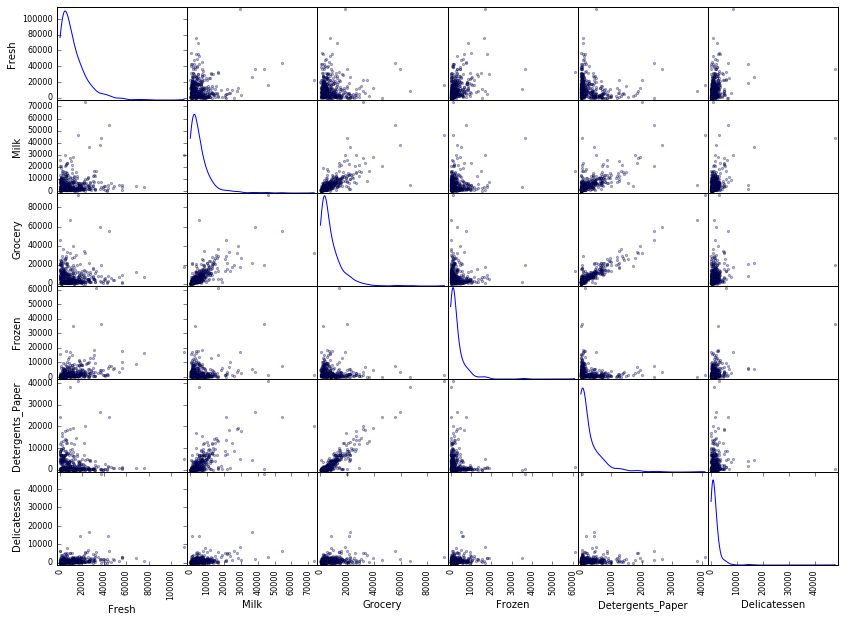

In [8]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,10), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**

Spending on the following product categories appear to be positively correlated with each other (that is all 3 possible pairs)

* Detergents_Paper,
* Grocery,
* Milk.

The scatter plots confirm my previous inference that the spending on Fresh goods is relevant to the identification of specific customers. We note further that our deduction of the three mentioned product categories being correlated is consistent with the results which find them at the bottom of Table Q2A.

From the plots, the data for these features appears to be log-normally distributed. The data is positively skewed (most data points are at the lower end with a few very high valued data points and Median<Mean).

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

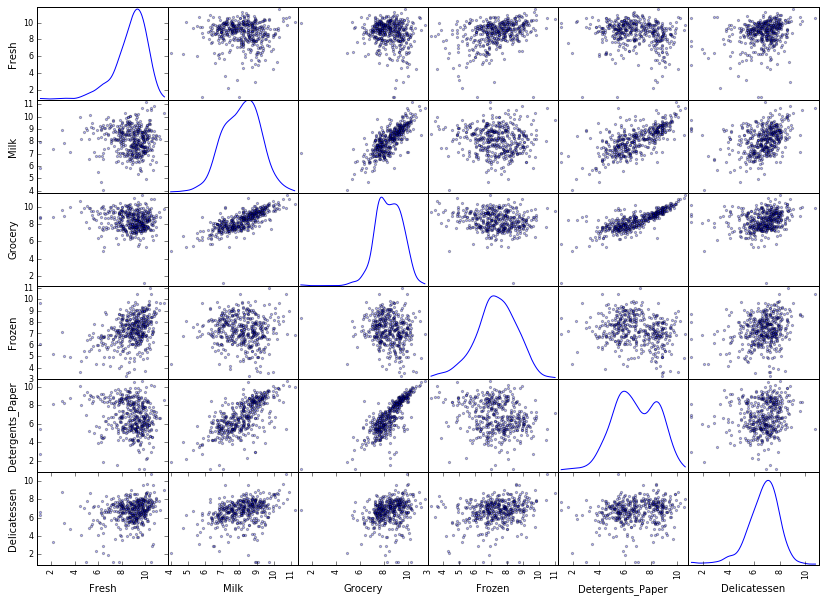

In [9]:
# TODO: Scale the data using the natural logarithm
log_data = np.log(data.copy())

# TODO: Scale the sample data using the natural logarithm
log_samples = np.log(samples.copy())

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,10), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [10]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.687630,10.740670,11.437986,6.933423,10.617099,7.987524
1,7.533159,6.357842,6.349139,6.856462,8.468423,5.313206
2,8.264621,8.243019,7.403061,6.775366,5.983936,8.482395


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
Once you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [11]:
# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature], 25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature], 75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*( Q3 - Q1 )
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))])

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


In [12]:
# Compare mean and median for log_data
display(log_data.describe().loc[['mean', '50%']])

all_outliers = [ 38,  57,  65,  66,  75,  81,  86,  95,  96,  98,
                109, 128, 137, 142, 145, 154, 161, 171, 175,
                183, 184, 187, 193, 203, 218, 233, 264, 285, 289,
                304, 305, 325, 338, 343, 353, 355, 356, 357,
                412, 420, 429, 439]

# Look at how much the outliers spend
display(total_spend[all_outliers].sort_values().describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
mean,8.730544,8.121047,8.441169,7.301396,6.785972,6.665133
50%,9.048286,8.196159,8.467057,7.330388,6.705018,6.872645


count        42.000000
mean      38868.095238
std       38896.340564
min         904.000000
25%       15387.000000
50%       30284.000000
75%       45738.750000
max      185683.000000
dtype: float64

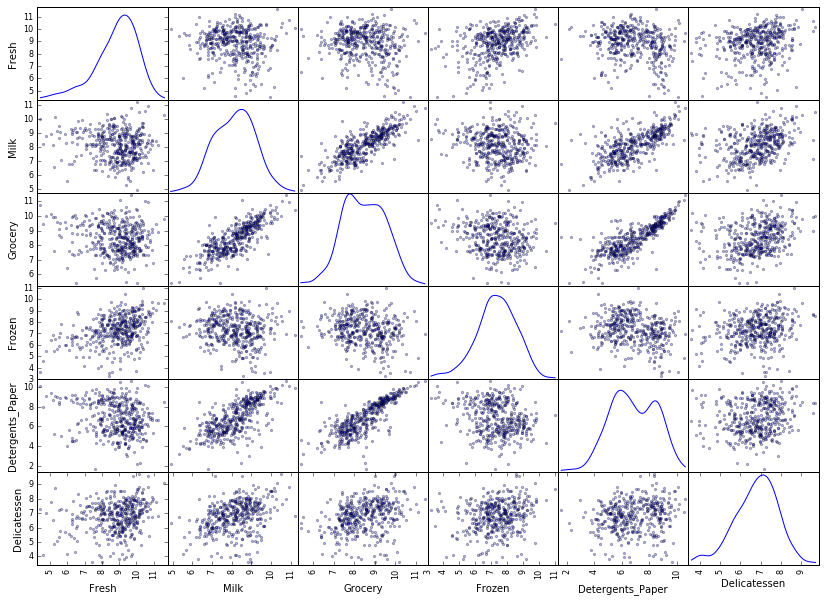

In [13]:
# Fresh      95   338   *66  218    96   357 | *65  412  353  *128  304  193  355  171  81  305
# Milk     *154    98 | 356   86
# Grocery   *75  *154 |
# Frozen    420    38   *65   57  145   429  175   264  439   325
# Deterg    *75   161 |
# Deli      109  *128  *142  187  233  *154  184  203  285  *289 | *66  137  343 | 183

# OPTIONAL: Select the indices for data points you wish to remove
outliers = [ 66, 75, 95, 96, 98, 109, 128, 142, 154, 161, 183, 184, 187, 203, 218, 233, 285, 289, 338, 357]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

# Look at the scatter plots again with ouliers removed
pd.scatter_matrix(good_data, alpha = 0.3, figsize = (14,10), diagonal = 'kde');

//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
//anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1283: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
//anaconda/lib/python2.7/site-packages/seaborn/linearmodels.py:1349: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `symmatplot` function has been deprecated in favor "


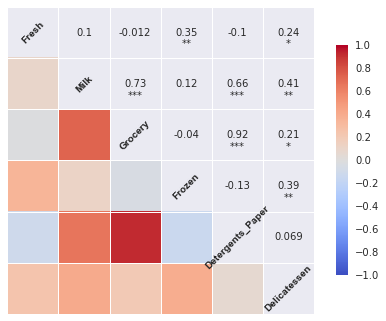

In [14]:
import seaborn as sns
sns.corrplot(data)

### Question 4
*Are there any data points considered outliers for more than one feature? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**

Using Tukey's Method we identify 42 outliers. Of these 5 are outliers for more than one product category, we lise these below:
*  65 - Fresh   & Frozen
*  66 - Fresh   & Delicatessen
*  75 - Grocery & Detergents_Paper
* 128 - Fresh   & Delicatessen
* 154 - Milk    & Grocery          & Delicatessen

We note that the outliers are mostly at the lower end of their product category. Some of the distributions appear to have a fat lower tail which makes determining which points might be outliers hard. We note, from the scatter plots, data points at the lower end of product category spending display more 'noise'. For example, the minimum value 1.098612 occurs numerous times for several product categories (four times for Delicatessen) with a much larger spread of values for the other product categories when compared to data points more central in the distribution.

Below we list the outliers for each product category in ascending order of value

|         | Fresh        |         | Milk      |         | Grocery  |         | Frozen    |         | Detergents_Paper |         | Delicatessen |
|---------|--------------|---------|-----------|---------|----------|---------|-----------|---------|-----------------|---------|--------------|
|  **95** |  1.098612    | **154** |  4.007333 |  **75** | 1.098612 | **420** |  3.218876 |  **75** | 1.098612          | **109** |  1.098612    |
| **338** |  1.098612    |  **98** |  4.718499 | **154** | 4.919981 |  **38** |  3.496508 | **161** | 1.098612          | **128** |  1.098612    |
|  **66** |  2.197225    | **356** |  4.89784  |         |          |  **65** |  3.583519 |         |                  | **142** |  1.098612    |
| **218** |  2.890372    |  **86** | 11.205013 |         |          |  **57** |  3.637586 |         |                  | **187** |  1.098612    |
|  **96** |  3.135494    |         |           |         |          | **145** |  3.73767  |         |                  | **233** |  1.94591     |
| **357** |  3.610918    |         |           |         |          | **429** |  3.850148 |         |                  | **154** |  2.079442    |
|  **65** |  4.442651    |         |           |         |          | **175** |  3.951244 |         |                  | **184** |  2.397895    |
| **412** |  4.574711    |         |           |         |          | **264** |  4.110874 |         |                  | **203** |  2.890372    |
| **353** |  4.762174    |         |           |         |          | **439** |  4.174387 |         |                  | **285** |  2.890372    |
| **128** |  4.941642    |         |           |         |          | **325** | 11.016479 |         |                  | **289** |  3.091042    |
| **304** |  5.081404    |         |           |         |          |         |           |         |                  |  **66** |  3.295837    |
| **193** |  5.192957    |         |           |         |          |         |           |         |                  | **137** |  3.583519    |
| **355** |  5.247024    |         |           |         |          |         |           |         |                  | **343** |  3.610918    |
| **171** |  5.298317    |         |           |         |          |         |           |         |                  | **183** | 10.777768    |
|  **81** |  5.389072    |         |           |         |          |         |           |         |                  |         |              |
| **305** |  5.493061    |         |           |         |          |         |           |         |                  |         |              ||


For each product category, we remove the outlier furthest to the left/right one at a time and look at the resulting scatter plots. We remove those points which lie outside of the general pattern of the data visually in the scatter plots. These points add noise and detract from the structure of the data. For example in PCA they will pull the mean lower and impact the covariances disproportionaltely.

With this in mind we remove the left most...
* six data points for the Fresh product category
* two data points for the Milk product category
* two data point for the Grocery product category
* zero data points for the Frozen product category
* two data points for the Detergents_Paper product category
* ten and right most data point for the Delicatessen product category

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. 

In the code block below, you will need to implement the following:
 - Import `sklearn.preprocessing.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

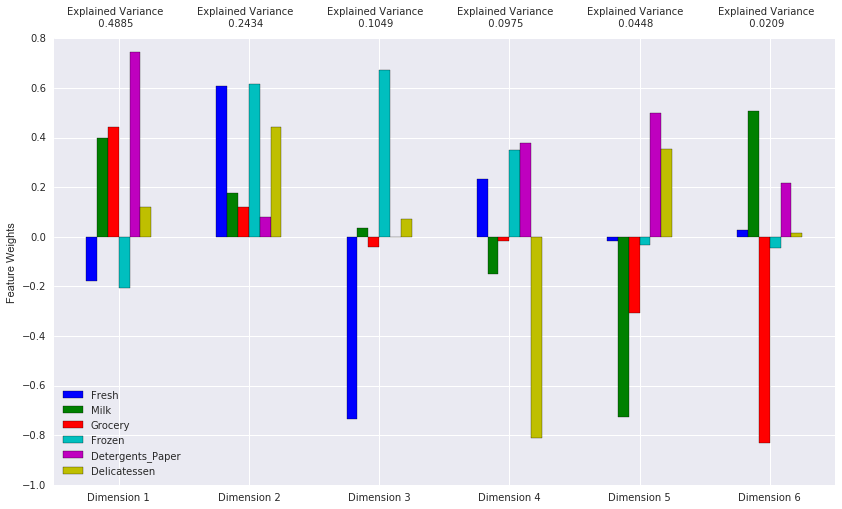

In [15]:
# TODO: Apply PCA to the good data with the same number of dimensions as features
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(good_data)

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,-0.180007,0.399475,0.442725,-0.206257,0.744804,0.121394
1,0.608551,0.177452,0.121724,0.617268,0.078288,0.442956
2,-0.735629,0.036156,-0.039544,0.671503,0.000687,0.071144
3,0.234652,-0.149415,-0.018261,0.349595,0.376742,-0.811252
4,-0.015242,-0.727219,-0.305430,-0.033600,0.500828,0.354508
5,0.028619,0.506410,-0.833063,-0.046641,0.215347,0.013668


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


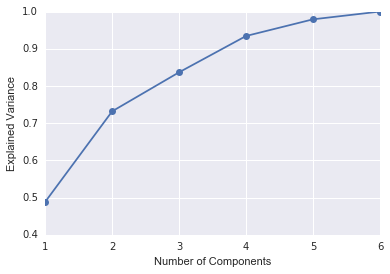

In [16]:
pca_df = pd.DataFrame(pca.components_, columns = good_data.keys())
display(pca_df)

%pylab inline
import matplotlib.pyplot as plt

plt.plot(np.arange(1,7), np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**

73% of the variance is explained by the first two components and 94% of the variance is explained by the first four components.

We can view each product category as a dimension in a cartesian co-ordinate system. From this vantage point, each dimension in our PCA results is then a basis vector for a new set of co-ordinates, obtained via a linear transformation. Our new coordinates are centred at the mean of the data and are oriented such that, each component is a direction of maximal variation of our data, in descending order of magnitude. In other words, the first dimension is the direction of the axis of maximum variation. The second dimension is the direction of the axis of maximal variation of all possible directions orthogonal to the first axis. The third dimension is the direction of the axis of maximal variation of all possible directions orthogonal to the first two axes and so on.

Since the new co-ordinates are obtained by a linear transform, each principal component can be written as a linear combination of the original product categories. The components express the correlation to the original product categories, so a positive contribution from a product category means the component increases as that product category increases and a negative contribution means the component decreases as the product category increases. The size of the contribution indicates the relative size of that increase or decrease.

By the nature of our new co-ordinates (i.e. they are directions of maximal variation), the components not only express their correlation to the original product categories but the correlation between them too - they reveal spending patterns of the customers. The diagram and table (pca_df) above shows the proportions of each product category spending, above (or below) the mean, which compose each principal component.

<u>First principal component in descending order of contribution from product categories</u>:

| Detergents_Paper	| Grocery | Milk | Frozen | Fresh | Delicatessen |
|-------------------|---------|------|--------|-------|--------------|
| 0.74              | 0.44    | 0.40 | -0.21  | -0.18 | 0.12         |

In our data we can see that the (first) principal component is made up of relatively large positive contributions from Detergents_Paper, Grocery and Milk (compared to the other three product categories). This is consistent with the results in which show there product categoriess at the bottom of Table Q2A and corroborates the positive correlation observed between them in the scatter plots earlier (Question 3 Answer). One might consider these products household staples which are bought in similar proportions (approximately 74 : 44 : 40) above or below the mean (but different quantities) by a large proportion of the customers.

<u>Second principal component in descending order of contribution from product categories</u>:

| Frozen | Fresh | Delicatessen | Milk | Grocery | Detergents_Paper |
|--------|-------|--------------|------|---------|------------------|
| 0.62   | 0.61  | 0.44         | 0.18 | 0.12    | 0.0078           | 

The second principal component consists of large positive contributions from frozen and fresh product categories in similar proportions and delicatessen items a little less (62 : 61 : 44). This could represents the second most popular combination of product categories bought together.

We note that the first two components seem to almost split the product categories into two groups. The first principal component contains items one can keep in a cupboard and do not require chilling. The second component contains items which require chilling in a fridge or freezer. Milk comes in many forms (fresh, long life, powdered) some of which require chilling and other which do not, this could explain why positive contributions from Milk can be found in both components.

The third and fourth principal components explain only 10% of the variance in our data each. We find they are extemely sensitive to ouliers - the first two components are much less sensitive in comparison.

<u>Third principal component in descending order of contribution from product categories</u>:

| Fresh | Frozen | Delicatessen | Grocery | Milk  | Detergents_Paper |
|-------|--------|--------------|---------|-------|------------------|
| -0.74 | 0.67   | 0.071        | -0.040  | 0.036 | 0.00069          |

The third principal component consists of offsetting Fresh and Frozen product contributions (-74 : 67) from the mean.

<u>Fourth principal component in descending order of contribution from product categories</u>:

| Delicatessen | Detergents_Paper | Frozen  | Fresh | Milk  | Grocery  |
|--------------|------------------|---------|-------|-------|----------|
| -0.82        | 0.38             | 0.34    | 0.23  | -0.15 | -0.018   |

The fourth principal component consists of a well below average contribution from spending on Delicatessen products and above average spending on Detergents_Paper and Frozen product categories (-82 : 38 : 34).

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [17]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,5.2306,1.9206,-0.8221,0.0589,-0.4742,-0.2966
1,-0.2945,-2.1880,0.5621,1.6343,2.2787,1.1659
2,-0.6555,-0.1208,0.2198,-2.0304,0.4566,0.7756


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [18]:
# TODO: Fit PCA to the good data using only two dimensions
pca = PCA(n_components=2)
pca.fit(good_data)

# TODO: Apply a PCA transformation the good data
reduced_data = pca.transform(good_data)

# TODO: Apply a PCA transformation to the sample log-data
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [19]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,5.2306,1.9206
1,-0.2945,-2.1880
2,-0.6555,-0.1208


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**

K-Means can be described as a hard boundary version of a Gaussian Mixture Model (GMM). The algorithms are very similar in that both algorithms require the number of clusters to be input, both algorithms recursively determine the relation of each data point to the cluster centres and then adjust the location of the cluster centres to the expected location based on those relations. The algorithms differ in that K-Means determines a single cluster centre to which each data point belongs by that which is closest. In other words each point belongs to the closest cluster centre with probability one and to the other cluster centres with probability zero. GMMs on the other hand assume each cluster centre generates data points according to a Gaussian distribution so each data point belongs to each and every cluster centre with some non-zero probability.

K-means is a simpler algorithm and is fast compared to Gaussian Mixture Model since it does not require calculation of probabilities or covariances. Though that speed difference is inconsequential for out data set size and shape.

Some disadvantages of K-means over Gaussian Mixture Models are that K-means does not model overlapping clusters and does not take into account the shape of the data by allowing for different covariance matricies in different clusters as GMM does. This means that it does not preform well in cases where cluster centres are very close or where the shape of the data is more important than the distance from the cluster centre in identifying clusters.

Looking at our scatter plots, we can see overlapping pairs of clusters in some of the scatter plots, and clusters which are not circular in shape, however none of these occur in such a way that GMM would give us significantly different results to K-means. For this reason we choose K-Means over Gaussian Mixture Model.

### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [20]:
# TODO: Apply your clustering algorithm of choice to the reduced data

#from sklearn.mixture import GMM
#clusterer = GMM(n_components=2, random_state=0)

from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters=2, random_state=0)

# TODO: Predict the cluster for each data point
preds = clusterer.fit_predict(reduced_data)

# TODO: Find the cluster centers
#centers = clusterer.means_
centers = clusterer.cluster_centers_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
from sklearn.metrics import silhouette_score
score = silhouette_score(reduced_data, preds)
print score

0.442307298411


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**

| `n_clusters` | `KMeans silhouette_score` | `GMM silhouette_score` |
|--------------|---------------------------|------------------------|
| 2            | 0.432723160376            | 0.427349342468         |
| 3            | 0.353685953861            | 0.295254077547         |
| 4            | 0.331816995659            | 0.315975101211         |
| 5            | 0.353102937212            | 0.28948756656          |
| 6            | 0.363439400385            | 0.31932462294          |

`n_clusters=2` has the best `silhouette_score`. This is consistent with our scatter plots and observed bi-modal distributions.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

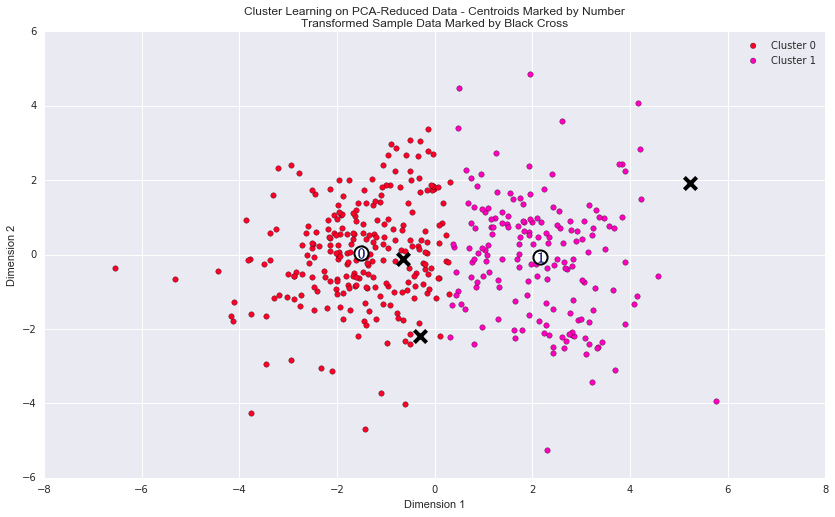

In [21]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [22]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

mean_centred_df = true_centers - data.mean()
size = (mean_centred_df**2.0).sum(axis=1)**0.5
display(mean_centred_df.div(size, axis=0))

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,9290,1925,2457,2125,310,747
Segment 1,4536,8162,12268,942,4700,1116


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,-0.348064,-0.497159,-0.705591,-0.121608,-0.330239,-0.099896
Segment 1,-0.795890,0.252249,0.460276,-0.227107,0.193901,-0.043596


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**

Segment 0:

| Grocery | Milk | Detergents_Paper | Delicatessen | Frozen | Fresh  |
|---------|------|------------------|--------------|--------|--------|
| 0.47    | 0.25 | 0.18             | -0.043       | -0.22  | -0.80  |

This representative customer spends above average on Grocery, Milk and Detergents_Paper product categories (cupboard or non-chilled items) and below average on Delicatessen, Frozen and Fresh products. I would guess any data point very close to this cluster centre would likely be a convenience store and the customer segment likely represents retail stores.

Segment 1:

| Delicatessen | Frozen | Detergents_Paper | Fresh | Milk  | Grocery |
|--------------|--------|------------------|-------|-------|---------|
| -0.10        | -0.12  | -0.32            | -0.37 | -0.49 | -0.70   |

This representative customer spends below average on all product categories but spends more on Delicatessen and Frozen products relatively speaking. Any point close to this cluster centre might represent a fast food restaurant while the cluster itself contains restaurants and hotels.

We note that our cluster centres have significantly different values along our first principal component but have similar values in our second principal component.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [23]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 0


**Answer:**

In question 1 I guessed my sample points were a convenience store, a guesthouse and a sandwich shop, so they are best represented by segments 0, 1 and 1 respectively. The sample points were predicted to belong to clusters 0, 1 and 1 respectively. The prediction is consistent with my description of the segements as a convenience store and fast food or sandwich bar style restaurant.

## Conclusion

### Question 10
*Companies often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services. If the wholesale distributor wanted to change its delivery service from 5 days a week to 3 days a week, how would you use the structure of the data to help them decide on a group of customers to test?*  
**Hint:** Would such a change in the delivery service affect all customers equally? How could the distributor identify who it affects the most?

**Answer:**

A/B tests can be used as a way to assess the impact (on some 'output variable') of making a small change, or choosing between two possible variants of an 'input variable' to optimise an output variable. The basic idea is to carry out an experiment on two test groups where the two groups are sampled randomly from the same population and differ only by one binary 'input variable'. We can then measure the output variable and use hypothesis testing to understand if any differences between the test groups are statistically significant and ultimately make a choice about whether to make the change or which variant to choose.

Some typical examples of where A/B testing is used:
* To decide between two variants of a web page. In this case the binary input variable would be the web page itself (variant A and variant B) and the output variable might be the proportion of customers in the test group which click on the desired link.
* To measure the effectiveness of a drug, the binary input variable here would be whether the patient is given the drug (test group A) or a placebo (test group B - the control group) and the output variable could be the average change in some health metric (which indicates the level of illness of the patient) after the drug (or placebo) is administered.

In our case the change we are interested in making is a reduction in the delivery service from five to three days a week. We have found our customers fall into one of two possible segments (0 or 1). In order to identify which segment would be more affected more by a change in the delivery service we could sample independently from each cluster to create the two test groups. Test group A would be a sample of customers from segment 0 and test group B a sample of customers from segment 1. Here the binary input variable is the customer segment to which the customer belongs. We could then implement the change in delivery service for both test sets and see how their spending patterns change in response. So our output variable might me the average change in spending for the test group across the product categories between the week/month before and after the change in the delivery service.

### Question 11
*Assume the wholesale distributor wanted to predict some other feature for each customer based on the purchasing information available. How could the wholesale distributor use the structure of the data to assist a supervised learning analysis?*

**Answer:**

Apart from the additional insight we have gained into the nature of our data and the driving features, the structure we have found in the data can be used to reduce noise and the dimensionality of the data we have. That is, we could use the first say two principal componants instead of our original six product categories. This would enable us to get more effective results with smaller datasets to train our supervised learning algorithm on. Along with our principal componants as new features we could also use the clusters we have found as a new feature.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier on to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

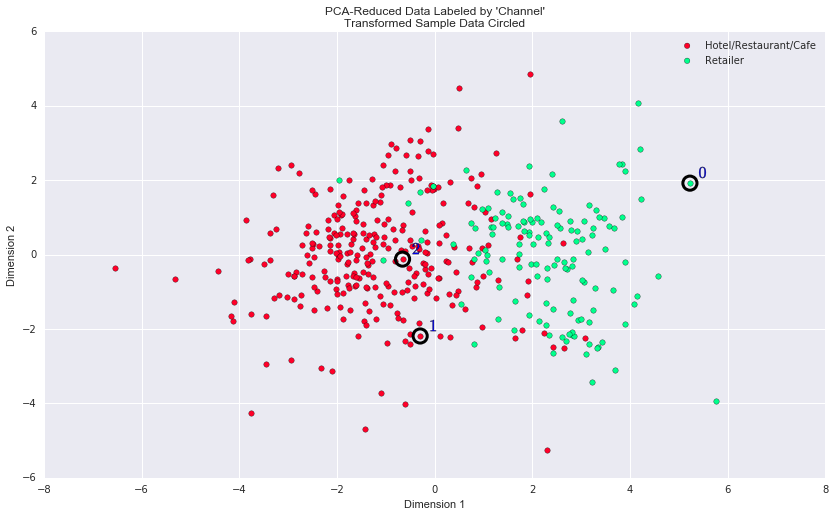

In [24]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**

Our clusters compare well with the given underlying distribution of Hotel/Restaurant/Cafe to Retailer customer types. We found two clusters in our data and these correspond to the segments above, that is, cluster 0 aligns roughly with Retailers and cluster 1 aligns roughly with Hotel/Restaurant/Cafe, this is consistent with our guess. We note that as mentioned above (Question 6 Answer) the clusters are more overlapping than was obvious from the clusters we found earlier and the cluster centres are closer than predicted but the general pattern is similar. Customers who score large and negaive values of the principal components are most likely Retailers and those who score large and negative values are most likely a Hotel, Restaurant or Cafe. This is consistent with the way we defined our customer segments earlier.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.